**Felipe Barreto y Laura Martínez**

# **Logistic Regression with a Neural Network mindset**

The [dataset](https://www.kaggle.com/datasets/mattop/panda-or-bear-image-classification/data) contains panda and bear images generated by DALL-E Mini, an AI model that draws images from any prompt. The task for this dataset is binary classification.

## **1 - Packages**

In [35]:
# Imports
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import glob
import requests

## Imports para el preprocesamiento de imagenes
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## **2 - Overview of the problem set**

In [ ]:
# Upload dataset
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


## **Another method to import the dataset**

In [ ]:
# Import Train of bears

bearsTrain = []
for fileName in glob.glob('/content/gdrive/MyDrive/Semestre 10/IA 2/PandasBears/Train/Bears/*.jpeg'):
    im = Image.open(fileName)
    bearsTrain.append(np.asarray(im))

bearsTrain = np.array(bearsTrain)
print(len(bearsTrain))

In [ ]:
# Import train of Pandas

pandasTrain = []
for fileName in glob.glob('/content/gdrive/MyDrive/Semestre 10/IA 2/PandasBears/Train/Pandas/*.jpeg'):
    im = Image.open(fileName)
    pandasTrain.append(np.asarray(im))

pandasTrain = np.array(pandasTrain)
print(len(pandasTrain))
print(pandasTrain[0])

## **Kaggle test to import the dataset**

In [36]:
## Number of images the model is going to use to train (max 500)
batch_size_train = 500

## Number of images the model is going to use to test (max 100)
batch_size_test = 100

# Keras ImageDataGenerator class provides a quick and easy way to augment the images
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


# Generates batches of augmented image data. It applies different transformations.
train_generator = train_datagen.flow_from_directory(
    #'/content/gdrive/MyDrive/u/Semestre 8/ia/datasets/PandasBears/Train',
    '/content/gdrive/MyDrive/Semestre 10/IA 2/PandasBears/Train',
    target_size = (256, 256), #image resolution
    batch_size = batch_size_train,
    class_mode = 'binary' #adds the label 1 for panda 0 for other bears
)

test_generator = test_datagen.flow_from_directory(
    #'/content/gdrive/MyDrive/u/Semestre 8/ia/datasets/PandasBears/Train',
    '/content/gdrive/MyDrive/Semestre 10/IA 2/PandasBears/Test',
    target_size = (256, 256), #image resolution
    batch_size = batch_size_test,
    class_mode = 'binary' #adds the label 1 for panda 0 for other bears
)

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


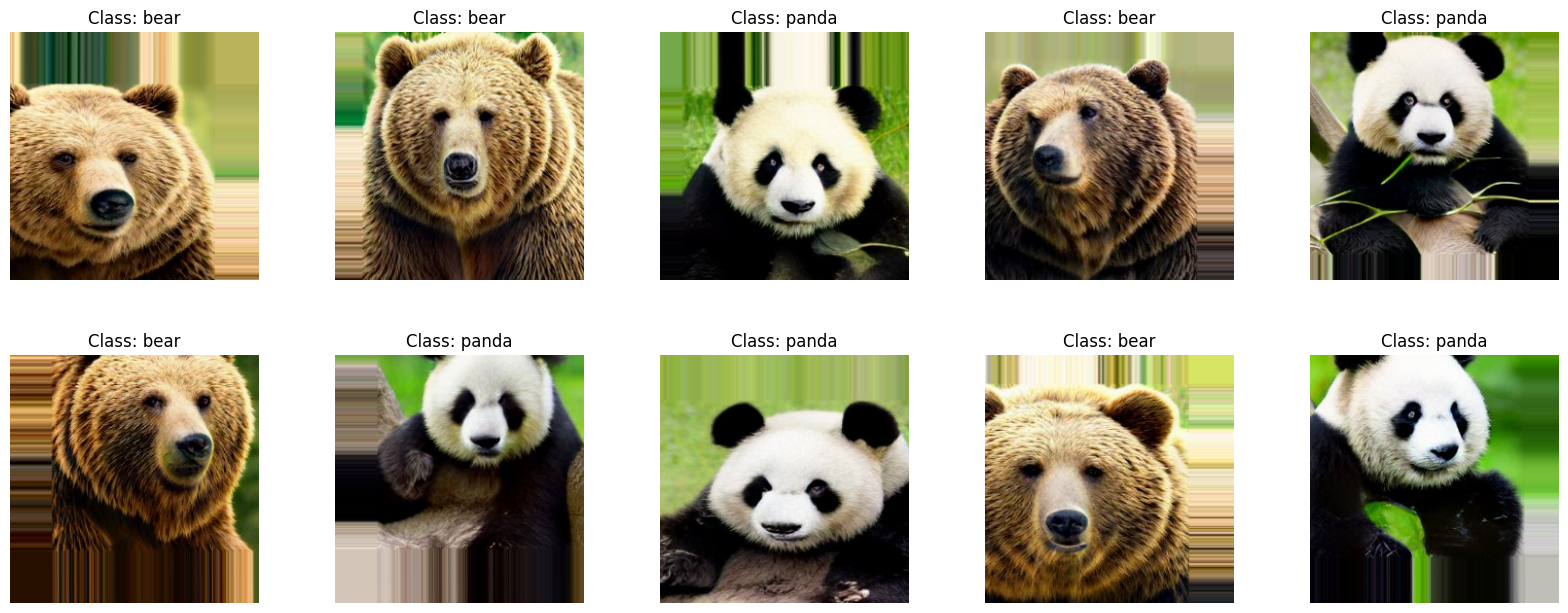

In [37]:
# Here we convert the target label to an integer index and display a grid of 10 images along with their corresponding class labels

labels = ['bear', 'panda']

samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [38]:
# Getting numpy arrays from the generators

train_set_x_orig, train_set_y = next(train_generator) # returns a 2 numpy arrays, the first one is of the shape (batch_size, pixel height, pixel weidth, color channels (3)). the second is the labels for the images (1 or 0)
test_set_x_orig, test_set_y= next(test_generator)

In [39]:
# We don't want this types of shapes so we have to use re-shape

print(train_set_y.shape)
train_set_y = train_set_y.reshape((1, batch_size_train))
print(train_set_y.shape)

print(test_set_y.shape)
test_set_y = test_set_y.reshape((1, batch_size_test))
print(test_set_y.shape)

(500,)
(1, 500)
(100,)
(1, 100)


y = 0.0, it's a bear


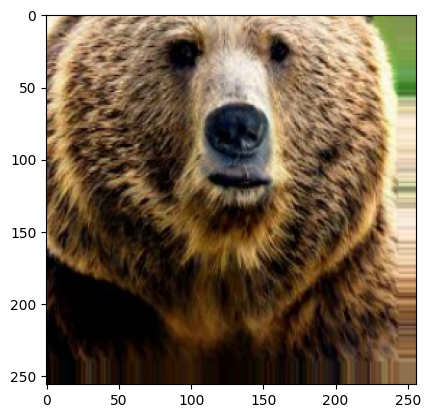

In [40]:
# Example of a picture with it's label

labels = ['bear', 'panda']

index =10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0,index]) + ", it's a " + f"{labels[int(train_set_y[0,index])]}")

In [41]:
# We make sure the arrays are in the shapes we want

m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 500
Number of testing examples: m_test = 100
Height/Width of each image: num_px = 256
Each image is of size: (256, 256, 3)
train_set_x shape: (500, 256, 256, 3)
train_set_y shape: (1, 500)
test_set_x shape: (100, 256, 256, 3)
test_set_y shape: (1, 100)


In [42]:
# Reshape the training and test examples
# We flatten the arrays so they can be used later on

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (196608, 500)
train_set_y shape: (1, 500)
test_set_x_flatten shape: (196608, 100)
test_set_y shape: (1, 100)
sanity check after reshaping: [0.3072707  0.06334356 0.5711262  0.46274513 0.14293097]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize the dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [43]:
# Standardization of the arrays
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## **3 - Building the parts of our algorithm**

The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
  - Calculate current loss (forward propagation)
  - Calculate current gradient (backward propagation)
  - Update parameters (gradient descent)
You often build 1-3 separately and integrate them into one function we call model().

### **3.1 - Helper functions**

In [44]:
# Sigmoid funtion

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    #Sigmoid function
    s = 1/(1+np.exp(-z))


    return s

In [45]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### **3.2 Initializing parameters**

In [46]:
# Initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """


    w = np.zeros((dim,1))
    b = 0


    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [47]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### **3.3 - Forward and Backward propagation**

In [48]:
# Propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost


    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [49]:
# This output provides insight about how well the model is performing
# and how the parameters should be updated during training to minimize the cost function

w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### **3.4 - Optimization**



We already initialized the parameters and computed a cost function and its gradient. Now, we want to update the parameters using gradient descent.

So, the goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [50]:
# Optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)


        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [51]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

**1.** Calculate $\hat{Y} = A = \sigma(w^T X + b)$

**2.** Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this).

In [52]:
# Predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a panda being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)


    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [53]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


### **4 - Merge all functions into a model**

Now we will see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together and in the right order.

In [ ]:
# Model

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """



    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [56]:
# Run model to see train and test accuracy

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = 0.05, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.692886
Cost after iteration 200: 0.692633
Cost after iteration 300: 0.692388
Cost after iteration 400: 0.692151
Cost after iteration 500: 0.691920
Cost after iteration 600: 0.691696
Cost after iteration 700: 0.691478
Cost after iteration 800: 0.691266
Cost after iteration 900: 0.691059
Cost after iteration 1000: 0.690858
Cost after iteration 1100: 0.690661
Cost after iteration 1200: 0.690470
Cost after iteration 1300: 0.690282
Cost after iteration 1400: 0.690099
Cost after iteration 1500: 0.689919
Cost after iteration 1600: 0.689744
Cost after iteration 1700: 0.689572
Cost after iteration 1800: 0.689403
Cost after iteration 1900: 0.689238
Cost after iteration 2000: 0.689075
Cost after iteration 2100: 0.688916
Cost after iteration 2200: 0.688759
Cost after iteration 2300: 0.688605
Cost after iteration 2400: 0.688454
Cost after iteration 2500: 0.688305
Cost after iteration 2600: 0.688159
Cost after iteration 2700: 0.688014
Cost

y = 0.0
y = 0.0, it's a bear


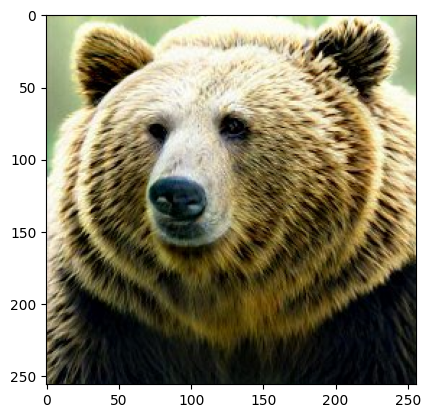

In [61]:
# Example of a picture

index = 13
plt.imshow(test_set_x_orig[index])
print ("y = " + str(test_set_y[0,index]))
print ("y = " + str(train_set_y[0,index]) + ", it's a " + f"{labels[int(train_set_y[0,index])]}")

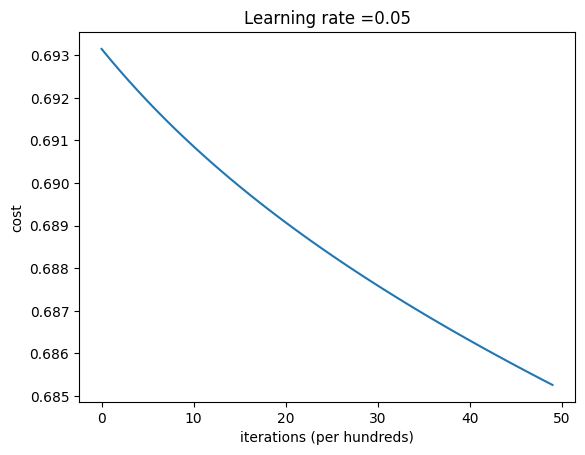

In [62]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### **5 - Further analysis**

In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

learning rate is: 0.01
train accuracy: 54.8 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 55.199999999999996 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 54.8 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.03
train accuracy: 54.8 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.003
train accuracy: 54.6 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.0003
train accuracy: 55.199999999999996 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.05
train accuracy: 55.4 %
test accuracy: 51.0 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 54.6 %
test accuracy: 51.0 %

--------------

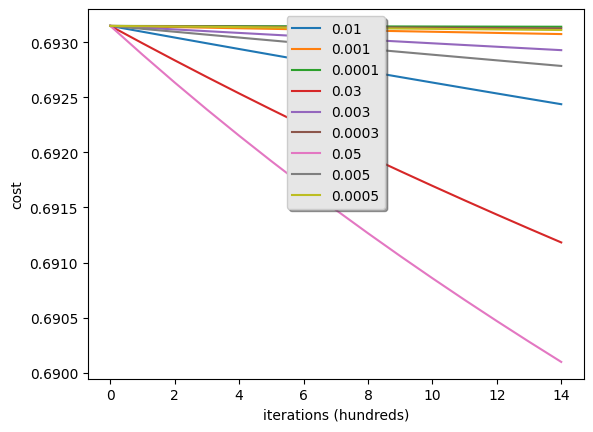

In [64]:
# Testing different learning rates
learning_rates = [0.01, 0.001, 0.0001, 0.03, 0.003, 0.0003, 0.05, 0.005, 0.0005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**:
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge.
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you:
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting.


### **6 - Test with your own image**

Image Height       :  192
Image Width        :  261
Number of Channels :  3
New dimensions 256 256 3


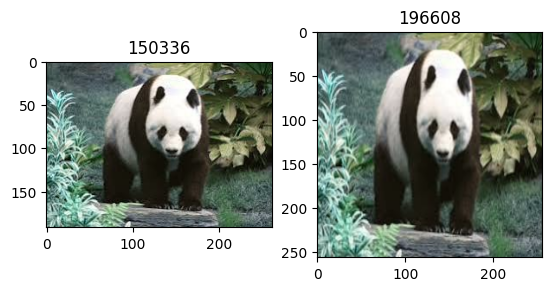

In [65]:
import cv2

# read image
img = cv2.imread('/content/gdrive/MyDrive/Semestre 10/IA 2/test.jpg', cv2.IMREAD_UNCHANGED)

# get dimensions of image
dimensions = img

# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

h, w, c = img.shape

# new resized image
resizedImage = cv2.resize(img, (256, 256))

h, w, c = resizedImage.shape

print ("New dimensions", h, w, c)

def plot_image(img1, img2):
    plt.subplot(1, 2, 1)

    plt.imshow(img1)
    plt.title(img1.size)

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(img2.size)

    plt.show()

plot_image(img, resizedImage)

In [66]:
labels = ['bear', 'panda']

my_image = '/content/drive/MyDrive/Semestre 10/IA 2/test.jpg'   # change this to the name of your image file

my_image = resizedImage.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
print(my_predicted_image)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a " + f"{labels[int(np.squeeze(my_predicted_image))]}")

[[1.]]
y = 1.0, your algorithm predicts a panda
